In [34]:
#imports
try:
    from google.colab import drive
    #mount drive, set base path
    drive.mount("/gdrive")
    base_path = '/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites'
except:
    base_path = './'
from pathlib import Path
import matplotlib.pyplot as plt
import random
from random import randint, choice

import time

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

from tqdm.auto import tqdm
import numpy as np
from PIL import Image

import copy


In [35]:
torch.cuda.is_available()

True

In [36]:
#utility functions for:
# setting the seed
# ensuring randomness of worker in data loader (overkill?)
# setting the device based on GPU availability

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

## Load data

In [37]:
#dataset paths
#set these paths and file names depending on where you are and which labels you are using

data_path = Path(base_path).joinpath('processed/')
train_images_path = Path(data_path).joinpath('training_images_rand4_unique.npy')
train_labels_path = Path(data_path).joinpath('training_objareas_rand4_unique.npy')
val_images_path = Path(data_path).joinpath('validation_images_rand4_unique.npy')
val_labels_path = Path(data_path).joinpath('validation_objareas_rand4_unique.npy')

#get image area
train_imgarea_path = Path(data_path).joinpath('training_imgareas_rand4_unique.npy')
val_imgarea_path = Path(data_path).joinpath('validation_imgareas_rand4_unique.npy')

In [38]:
#load the numpy dataset files
train_images = np.load(train_images_path).astype(float)
train_labels = torch.tensor(np.load(train_labels_path).astype(float))
val_images = np.load(val_images_path).astype(float)
val_labels = torch.tensor(np.load(val_labels_path).astype(float))

#load image area files
train_imgarea = np.load(train_imgarea_path).astype(float)
val_imgarea = np.load(val_imgarea_path).astype(float)

In [39]:
# change labels so that they start at 0
# TODO this is only valid for counts - so we need a flag for this or change the generator or dataloader appropriately
train_labels = (train_labels)
val_labels = (val_labels)
print(train_labels, val_labels)

tensor([0.1436, 0.0273, 0.2351,  ..., 0.0793, 0.0178, 0.1162],
       dtype=torch.float64) tensor([0.1353, 0.2202, 0.1340,  ..., 0.1267, 0.1157, 0.0608],
       dtype=torch.float64)


Text(0.5, 1.0, 'object area: tensor(0.1682, dtype=torch.float64)')

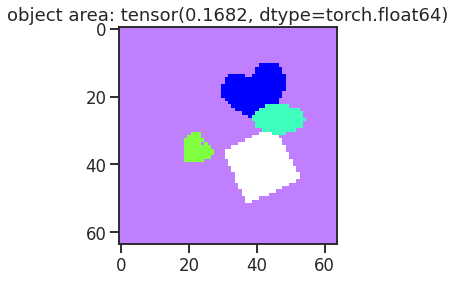

In [40]:
#examine data
idx = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[idx])
plt.title('object area: ' + str(train_labels[idx]))

## Prepare dataloaders for cnn

In [41]:
#define the dataset class for our data for use by the dataloader
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, images, labels, transform=None, target_transform=None):
        # assert all(tensors[0].size[0] == tensor.size[0] for tensor in tensors)
        self.images = images
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
          x = self.transform(x)

        y = self.img_labels[index]
        if self.target_transform:
          y = self.target_transform(y)

        return x.float(), y.float(), index

    def __len__(self):
        return len(self.img_labels)

In [42]:
#instantiate the dataset
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data =  CustomTensorDataset(train_images, train_labels, transform=train_transform)
val_data = CustomTensorDataset(val_images,val_labels,transform=train_transform)

In [43]:
#instantiate the dataloaders

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

BATCH_SIZE = 128  # number of examples per minibatch

train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           num_workers=12,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_data,
                                         shuffle=True,
                                         batch_size=BATCH_SIZE,
                                         num_workers=12,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Random seed 2021 has been set.
GPU is enabled in this notebook.


## CNN model for regression

In [44]:
# Create a sample network
class conv_net(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [45]:
# Create a sample network
class conv_net1(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [46]:
# Create a sample network
class conv_net2(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()

        return x

In [47]:
# Create a sample network
class conv_net2_cat(nn.Module):
    def __init__(self):
        super().__init__()
        # First define the layers.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    #     x = self.dropout(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)

        # Conv layer 3.
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = self.dropout(x)

        # Fully connected layer 1.
        x = torch.flatten(x,1)  # You have to first flatten the ourput from the
                                # previous convolution layer.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fully connected layer 2.
        x = self.fc2(x)
        x = x.squeeze()
#         x = F.log_softmax(x,dim=1)

        return x

In [48]:
def calc_error(output,target):
    return np.abs(output-target)/target

In [49]:
#define the train and test loops, and a wrapper that will call them to train and collect validation stats

def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
    """
    Trains the current inpur model using the data
    from Train_loader and Updates parameters for a single pass
    """
    device = args['device']
    model.train()
    for batch_idx, (data, target, index) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()

    return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
    """
    Tests the current Model
    """
    model.eval()
    test_loss = 0
    perc_error = 0
    
    with torch.no_grad():
        for data, target, index in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            perc_error += np.sum(calc_error(output.cpu().detach().numpy(),target.cpu().detach().numpy()))
    test_loss /= len(test_loader.dataset)
    perc_error /= len(test_loader.dataset)
    return test_loss, perc_error

def early_stopping_main(args, model, train_loader, val_loader, criterion, reg_function1=None, reg_function2=None):
    device = args['device']
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(),
                        lr=args['lr'])

    best_acc = 10
    best_epoch = 0

    # Number of successive epochs that you want to wait before stopping training process
    patience = 30

    # Keps track of number of epochs during which the val_acc was less than best_acc
    wait = 0

    val_acc_list, train_acc_list, val_error_list, train_error_list = [], [], [], []
    for epoch in tqdm(range(args['epochs'])):

        # train the model
        trained_model = train(args, model, train_loader, optimizer,
                              reg_function1=reg_function1,
                              reg_function2=reg_function2,
                              criterion=criterion)

        # calculate training accuracy
        train_acc, train_perc_error = test(trained_model, train_loader, criterion=criterion, device=device)

        # calculate validation accuracy
        val_acc, val_perc_error = test(trained_model, val_loader, criterion=criterion, device=device)

        if (val_acc < best_acc):
            best_acc = val_acc
            best_epoch = epoch
            best_model = copy.deepcopy(trained_model)
            wait = 0
        else:
            wait += 1

        if (wait > patience):
            print(f'early stopped on epoch: {epoch}')
            break

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_error_list.append(train_perc_error)
        val_error_list.append(val_perc_error)
#         print(train_acc, val_acc, train_perc_error, val_perc_error)
    #save the model
    if('checkpoint_path' in args):
        torch.save({
          'model_state_dict': best_model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, args['checkpoint_path'])

    return val_acc_list, train_acc_list, train_error_list, val_error_list, best_model, best_epoch


## Transfer from counting to object area estimation

In [17]:
import pandas as pd

import bebi103
from tqdm import tqdm

import iqplot
import bokeh.io
import holoviews as hv
from holoviews import opts
import colorcet as cc

bokeh.io.output_notebook()
hv.extension('bokeh')

bebi103.hv.set_defaults()


ModuleNotFoundError: No module named 'bebi103'

In [50]:
model_path = Path(base_path).joinpath('./pretrained/')
model1_path = Path(model_path).joinpath('cnn_reg_objarea_lr0.005_mmt0.8.pt')
model2_path = Path(model_path).joinpath('cnn2_reg_objarea_lr0.01_mmt0.8.pt')
model3_path = Path(model_path).joinpath('cnn3_reg_objarea_lr0.01_mmt0.8.pt')
model4_path = Path(model_path).joinpath('cnn3_reg_imgarea_lr0.01_mmt0.8.pt')
model5_path = Path(model_path).joinpath('cnn_reg_objcount_lr0.001_mmt0.8.pt')

model6_path = Path(model_path).joinpath('cnn3_cat_objcount_lr0.01_mmt0.8.pt')

## Fine tune network

In [23]:
model_ft = conv_net2_cat()
model_state_dict = torch.load(model6_path)['model_state_dict']
model_ft.load_state_dict(model_state_dict)

<All keys matched successfully>

In [24]:
for param in model_ft.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True


In [25]:
num_ftrs = model_ft.fc2.in_features
# reset final fully connected layer, number of classes = types of Pokemon = 9
model_ft.fc2 = nn.Linear(num_ftrs, 1)
model_ft.to(DEVICE)

conv_net2_cat(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

Random seed 2021 has been set.


early stopped on epoch: 111

Time to memorize the dataset: 819.6209626197815


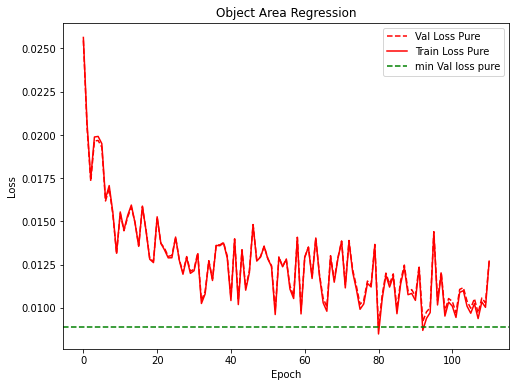

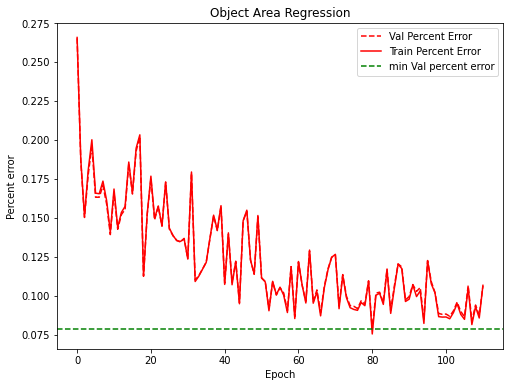

In [26]:
args = {
    'epochs': 300,
    'lr': 0.00038413048078536063,
    'momentum': 0.8,
    'device': DEVICE,
    'checkpoint_path':'./pretrained/cnn3_cat2reg_objarea_lr0.005_mmt0.8.pt'
}

set_seed(seed=SEED)

start_time = time.time()
# Train the network
# Train the network
val_loss_pure, train_loss_pure, train_error_list, val_error_list, model_ft, best_epoch= early_stopping_main(args=args,
                                                            model=model_ft,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=F.l1_loss)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_loss_pure, label='Val Loss Pure', c='red', ls='dashed')
plt.plot(train_loss_pure, label='Train Loss Pure', c='red', ls='solid')
plt.axhline(y=min(val_loss_pure), c='green', ls='dashed',
            label='min Val loss pure')
plt.title('Object Area Regression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_error_list, label='Val Percent Error', c='red', ls='dashed')
plt.plot(train_error_list, label='Train Percent Error', c='red', ls='solid')
plt.axhline(y=min(val_error_list), c='green', ls='dashed',
            label='min Val percent error')
plt.title('Object Area Regression')
plt.ylabel('Percent error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [33]:
#save the arrays for later use val_loss_pure, train_loss_pure, train_error_list, val_error_list
np.save("fine_tune_val_loss_pure", val_loss_pure)
np.save("fine_tune_train_loss_pure", train_loss_pure)
np.save("fine_tune_train_error_list", train_error_list)
np.save("fine_tune_val_error_list", val_error_list)

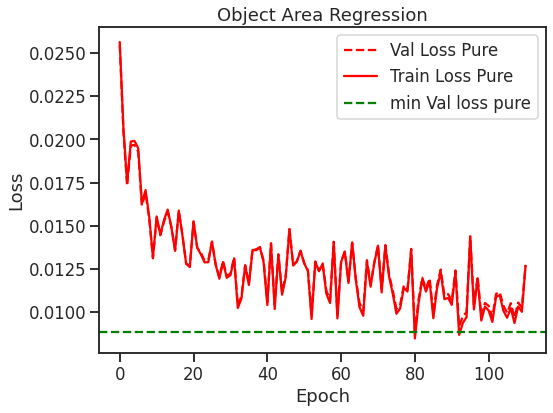

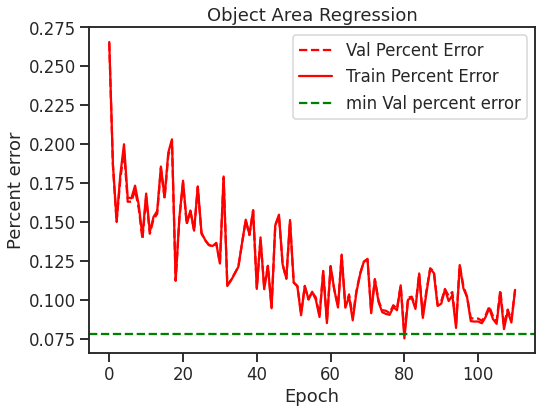

In [51]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_loss_pure, label='Val Loss Pure', c='red', ls='dashed')
plt.plot(train_loss_pure, label='Train Loss Pure', c='red', ls='solid')
plt.axhline(y=min(val_loss_pure), c='green', ls='dashed',
            label='min Val loss pure')
plt.title('Object Area Regression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_error_list, label='Val Percent Error', c='red', ls='dashed')
plt.plot(train_error_list, label='Train Percent Error', c='red', ls='solid')
plt.axhline(y=min(val_error_list), c='green', ls='dashed',
            label='min Val percent error')
plt.title('Object Area Regression')
plt.ylabel('Percent error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Only changing the classification layer

In [59]:
model_cl = conv_net2_cat()
model_state_dict = torch.load(model6_path)['model_state_dict']
model_cl.load_state_dict(model_state_dict)

<All keys matched successfully>

In [60]:
for param in model_cl.parameters():
    param.requires_grad = False

In [61]:
num_ftrs1 = model_cl.fc1.in_features
num_ftrs2 = model_cl.fc2.in_features

# replace fully connected layers
model_cl.fc1 = nn.Linear(num_ftrs1,num_ftrs2)
model_cl.fc2 = nn.Linear(num_ftrs2, 1)
model_cl.to(DEVICE)

conv_net2_cat(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [62]:
for param in model_cl.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
True
True
True
True


Random seed 2021 has been set.


early stopped on epoch: 59

Time to memorize the dataset: 345.61485719680786


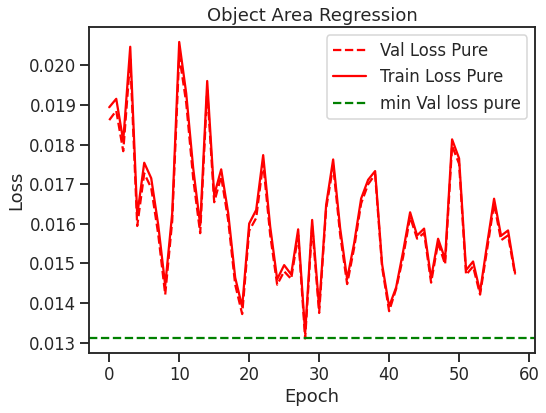

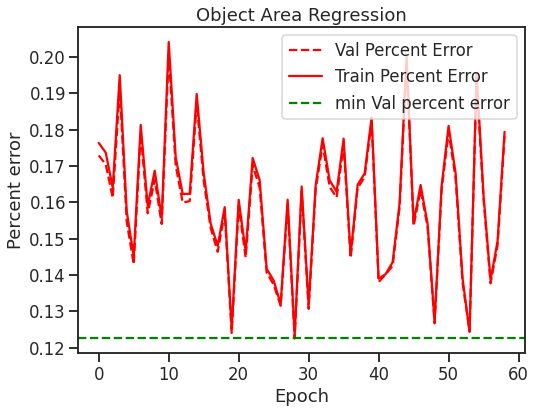

In [63]:
args = {
    'epochs': 300,
    'lr': 0.00038413048078536063,
    'momentum': 0.8,
    'device': DEVICE,
    'checkpoint_path':'./pretrained/cnn3_cat2reg_cl_objarea_lr0.005_mmt0.8.pt'
}

set_seed(seed=SEED)

start_time = time.time()
# Train the network
# Train the network
val_loss_pure, train_loss_pure, train_error_list, val_error_list, model_cl, best_epoch= early_stopping_main(args=args,
                                                            model=model_cl,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=F.l1_loss)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_loss_pure, label='Val Loss Pure', c='red', ls='dashed')
plt.plot(train_loss_pure, label='Train Loss Pure', c='red', ls='solid')
plt.axhline(y=min(val_loss_pure), c='green', ls='dashed',
            label='min Val loss pure')
plt.title('Object Area Regression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_error_list, label='Val Percent Error', c='red', ls='dashed')
plt.plot(train_error_list, label='Train Percent Error', c='red', ls='solid')
plt.axhline(y=min(val_error_list), c='green', ls='dashed',
            label='min Val percent error')
plt.title('Object Area Regression')
plt.ylabel('Percent error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [64]:
#save the arrays for later use val_loss_pure, train_loss_pure, train_error_list, val_error_list
np.save("final_classifer_val_loss_pure", val_loss_pure)
np.save("final_classifer_train_loss_pure", train_loss_pure)
np.save("final_classifer_train_error_list", train_error_list)
np.save("final_classifer_val_error_list", val_error_list)

## Training network from scratch

Time to memorize the dataset: 3046.4150750637054


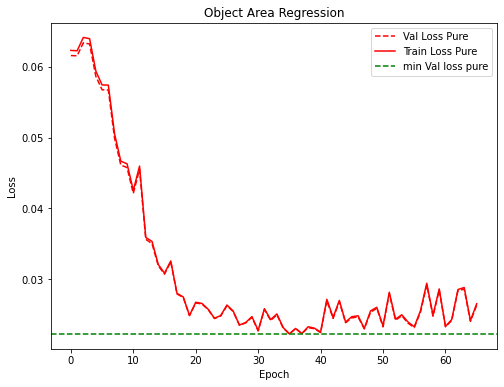

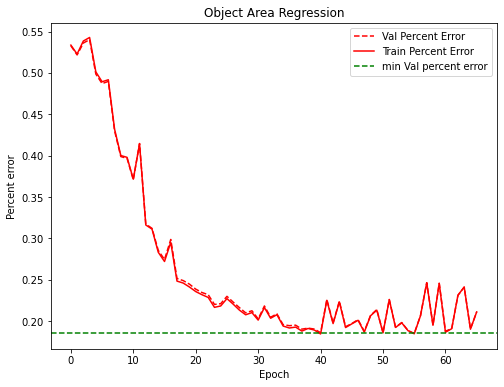

In [54]:
# args = {
#     'epochs': 300,
#     'lr': 0.005,
#     'momentum': 0.8,
#     'device': DEVICE,
#     'checkpoint_path':'/mnt/Data/Neuromatch/metamorphs/models/cnn3_reg_objarea_lr0.005_mmt0.8.pt'
# }

# set_seed(seed=SEED)

# model_sc = conv_net2()
# start_time = time.time()

# # Train the network
# val_loss_pure1, train_loss_pure1, train_error_list1, val_error_list1, model_sc, best_epoch1= early_stopping_main(args=args,
#                                                             model=model_sc,
#                                                             train_loader=train_loader,
#                                                             val_loader=val_loader,
#                                                             criterion=F.l1_loss)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_loss_pure1, label='Val Loss Pure', c='red', ls='dashed')
plt.plot(train_loss_pure1, label='Train Loss Pure', c='red', ls='solid')
plt.axhline(y=min(val_loss_pure1), c='green', ls='dashed',
            label='min Val loss pure')
plt.title('Object Area Regression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_error_list1, label='Val Percent Error', c='red', ls='dashed')
plt.plot(train_error_list1, label='Train Percent Error', c='red', ls='solid')
plt.axhline(y=min(val_error_list1), c='green', ls='dashed',
            label='min Val percent error')
plt.title('Object Area Regression')
plt.ylabel('Percent error')
plt.xlabel('Epoch')
plt.legend()
plt.show()